In [1470]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from IPython.display import Image
%matplotlib inline

# Initial data processing and exploratory analysis

In [1471]:
df = pd.read_csv('Crime_data.csv')

In [1472]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523591 entries, 0 to 523590
Data columns (total 11 columns):
Report Number                  523591 non-null int64
Occurred Date                  523589 non-null object
Occurred Time                  523589 non-null float64
Reported Date                  523591 non-null object
Reported Time                  523589 non-null float64
Crime Subcategory              523329 non-null object
Primary Offense Description    523591 non-null object
Precinct                       523585 non-null object
Sector                         520245 non-null object
Beat                           520293 non-null object
Neighborhood                   523591 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 43.9+ MB


In [1473]:
df.shape

(523591, 11)

In [1474]:
df.head()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
0,20080000465209,12/13/1908,2114.0,12/13/2008,2114.0,DUI,DUI-LIQUOR,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
1,20100000202011,06/15/1964,0.0,06/15/2010,1031.0,FAMILY OFFENSE-NONVIOLENT,CHILD-OTHER,WEST,Q,Q2,QUEEN ANNE
2,2012000023437,01/01/1973,0.0,01/25/2012,1048.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,NORTH,N,N2,NORTHGATE
3,20130000327785,06/01/1974,0.0,09/09/2013,1117.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,UNKNOWN,NaN,NaN,UNKNOWN
4,20160000289384,01/01/1975,0.0,08/11/2016,1054.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,UNKNOWN,NaN,NaN,UNKNOWN


Convert the date and time variables. There are 2 date variables, occurred date and reported date. We'll go with analyzing occurred date instead of reported date.

In [1475]:
df['Occurred Date'] = pd.to_datetime(df['Occurred Date'])
df['Reported Date'] = pd.to_datetime(df['Reported Date'])

In [1476]:
print(df['Occurred Date'].min())
print(df['Occurred Date'].max())
print(df['Reported Date'].min())
print(df['Reported Date'].max())

1908-12-13 00:00:00
2019-05-07 00:00:00
1975-12-16 00:00:00
2019-05-07 00:00:00


Looks like we have data over quite a long period of time, but for purposes of this project we'll restrict the analysis to crimes occuring in 2018.

In [1477]:
df = df[df['Occurred Date'].dt.year == 2018]

In [1478]:
df.shape

(51302, 11)

In [1479]:
# set index to Occurred Date
df.index = df['Occurred Date']

Next check for missing values in the dataset.

In [1480]:
df.isna().any()

Report Number                  False
Occurred Date                  False
Occurred Time                  False
Reported Date                  False
Reported Time                  False
Crime Subcategory              False
Primary Offense Description    False
Precinct                        True
Sector                          True
Beat                            True
Neighborhood                   False
dtype: bool

Some location variables have missing values, but for now, we'll do an overall analysis and remove those missing values later.

Let's first take a look at the number of crimes per subcategory.

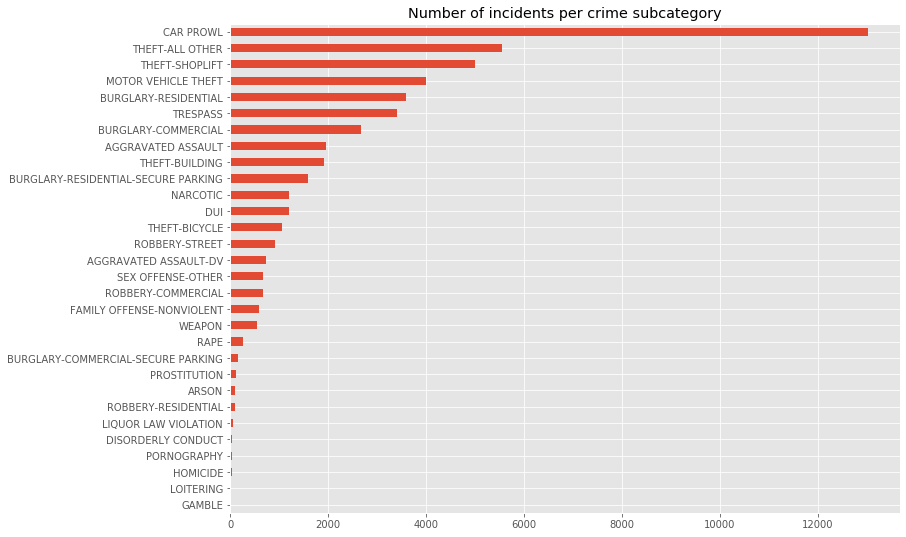

In [1481]:
plt.style.use('ggplot')
df['Crime Subcategory'].value_counts().sort_values().plot(kind='barh',
                                                          figsize=(12,9),
                                                         title= 'Number of incidents per crime subcategory');

Car prowl is by far the most popular crime occurring in Seattle. The next 3 most popular categories are that of theft. Property crime in general dominate the top spots in number of incidents per subcategory. 

How about the number of crimes by location?

Seattle is has 5 precincts or police stations. The precincts are further divided up into sectors,  and then beats as the smallest policing unit.    

<img src="precinctmap.png" alt="Drawing" style="width: 500px;"/>

There are 17 sectors, which we'll use as the location group for this analysis. We can roughly categorize the sectors as:
- N: Bitter Lake/ Northgate
- L: Lake City
- J: Green Lake
- B: Ballard/ Fremont
- U: University District/ Sandpoint
- Q: Magnolia/ Queen Anne
- D: South Lake Union
- C: Madison Valley
- E: Capitol Hill
- M: Downtown
- K: Pioneer Square
- G: Central District
- W: West Seattle
- F: West Georgetown
- O: East Georgetown
- R: Rainier Valley/ Beacon Hill North
- S: Rainier Valley/ Beacon Hill South

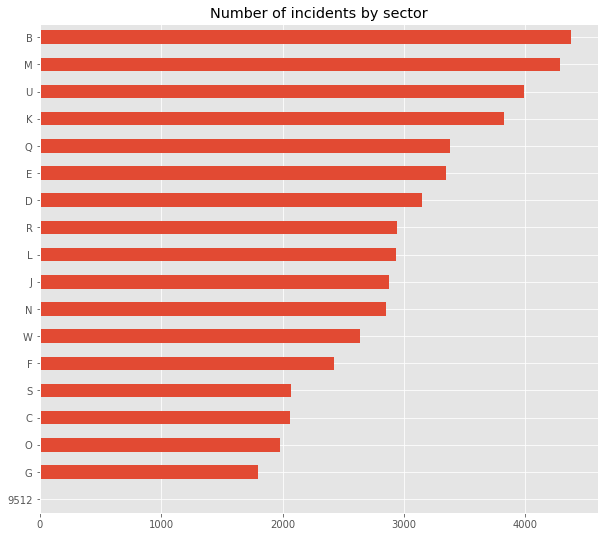

In [1482]:
df['Sector'].value_counts().sort_values().plot(kind='barh', figsize=(10,9),
                                              title='Number of incidents by sector');

The sectors with the most crime are B (Ballard/ Fremont), M (Downtown), and U (University District/ Sandpoint). 

We may be interested in the sectors that have the highest numbers of a particular type of crime, for example, violent crime, which we'll define as any robbery, assault, rape, homicide and weapon. Let's see what this looks like.

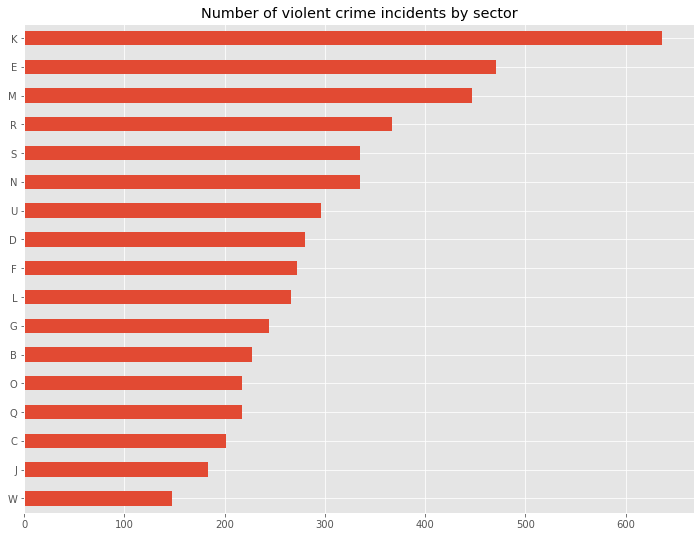

In [1483]:
#filtering violent crime
violent_crime = ([x for x in subcats if 'ROBBERY' in x or 'ASSAULT' in x] 
                 + ['RAPE', 'HOMICIDE', 'WEAPON'])
vc_df = df[df['Crime Subcategory'].isin(violent_crime)]

#plotting violent crime by sector
vc_df['Sector'].value_counts().sort_values().plot(kind='barh', figsize=(12,9),
                                                 title='Number of violent crime incidents by sector');

Looks like the distribution of violent crime by sector is pretty different from overall crime. K (Pioneer Square), E (Capitol Hill), and M (Downtown) are the sectors with the most violent crime. B (Ballard/ Fremont), which was the sector with the most overall crime has one of the lowest violent crime incidents by sector. 

We can also take a look at the frequency of incidents by month. 

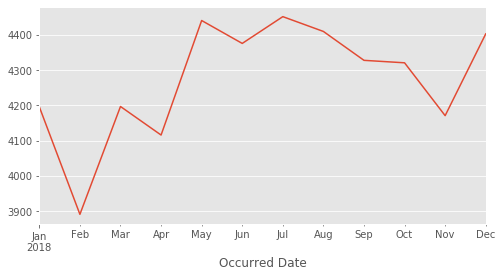

In [1484]:
df['Occurred Date'].resample('M').count().plot(figsize=(8,4));

Crime usually follows a seasonal trend- dipping in the winter and rising in the summer. Thus, it is rather unusual to see a spike in crime in December, and it would be interesting as a future project to investigate why this happened in 2018.

# Cluster analysis
It would be interesting to see if there is any natural grouping among the sectors as this could potentially be useful information to the police in terms of developing policing strategies and managing these sectors.

In order to do cluster analysis, we'll count up the number of incidents by sector for each crime category. In order to make the crime category, we'll aggregate the crime subcategories into larger categories.

In [1485]:
df['Crime Subcategory'].value_counts()

CAR PROWL                              13026
THEFT-ALL OTHER                         5562
THEFT-SHOPLIFT                          5011
MOTOR VEHICLE THEFT                     4006
BURGLARY-RESIDENTIAL                    3600
TRESPASS                                3405
BURGLARY-COMMERCIAL                     2681
AGGRAVATED ASSAULT                      1957
THEFT-BUILDING                          1912
BURGLARY-RESIDENTIAL-SECURE PARKING     1599
NARCOTIC                                1213
DUI                                     1213
THEFT-BICYCLE                           1055
ROBBERY-STREET                           921
AGGRAVATED ASSAULT-DV                    741
SEX OFFENSE-OTHER                        674
ROBBERY-COMMERCIAL                       672
FAMILY OFFENSE-NONVIOLENT                593
WEAPON                                   542
RAPE                                     273
BURGLARY-COMMERCIAL-SECURE PARKING       153
PROSTITUTION                             114
ARSON     

In [1486]:
#categorizing crime subcategories
subcats = df['Crime Subcategory'].unique()
subcats = list(subcats)

violent_crime = ([x for x in subcats if 'ROBBERY' in x or 'ASSAULT' in x] 
                 + ['RAPE', 'HOMICIDE', 'WEAPON'])
substance = ['NARCOTIC', 'DUI']
theft = [x for x in subcats if 'THEFT' in x or 'BURGLARY' in x]
property_crime = ['CAR PROWL', 'ARSON'] + theft
sex_crime = ['SEX OFFENSE-OTHER', 'PROSTITUTION', 'PORNOGRAPHY']
public = ['DISORDERLY CONDUCT', 'LOITERING', 'TRESPASS']

There are 2 incidents of 'GAMBLE' but since that doesn't really fit into any of the above categories, so we'll drop these 2 observations. 

In [1487]:
#drop GAMBLE
df = df[df['Crime Subcategory'] != 'GAMBLE']

#recategorizing
df['Crime Subcategory'].replace(violent_crime, 'VIOLENT', inplace=True)
df['Crime Subcategory'].replace(property_crime, 'PROPERTY', inplace=True)
df['Crime Subcategory'].replace(sex_crime, 'SEXUAL', inplace=True)
df['Crime Subcategory'].replace(substance, 'SUBSTANCE', inplace=True)
df['Crime Subcategory'].replace(public, 'PUBLIC', inplace=True)
df['Crime Subcategory'].replace('LIQUOR LAW VIOLATION', 'LIQUOR', inplace=True)
df['Crime Subcategory'].replace('FAMILY OFFENSE-NONVIOLENT', 'FAMILY', inplace=True)
df['Crime Subcategory'].value_counts()

PROPERTY     38704
VIOLENT       5235
PUBLIC        3456
SUBSTANCE     2426
SEXUAL         823
FAMILY         593
LIQUOR          63
Name: Crime Subcategory, dtype: int64

In [1488]:
#reshaping data by sector and aggregating counts
df = df[['Crime Subcategory', 'Sector', 'Report Number']]
df = df.groupby(['Sector','Crime Subcategory']).count().reset_index()
df = df.pivot(index='Sector', columns='Crime Subcategory', values= 'Report Number')
df

Crime Subcategory,FAMILY,LIQUOR,PROPERTY,PUBLIC,SEXUAL,SUBSTANCE,VIOLENT
Sector,,,,,,,
9512,NaN,NaN,1.0,NaN,NaN,NaN,NaN
B,22.0,6.0,3785.0,195.0,29.0,112.0,227.0
C,18.0,NaN,1521.0,169.0,33.0,123.0,201.0
D,12.0,1.0,2450.0,196.0,44.0,167.0,280.0
E,16.0,7.0,2054.0,508.0,64.0,228.0,471.0
F,46.0,2.0,1882.0,129.0,26.0,66.0,272.0
G,51.0,2.0,1165.0,174.0,45.0,117.0,244.0
J,32.0,4.0,2393.0,130.0,39.0,93.0,183.0
K,26.0,6.0,2470.0,335.0,73.0,281.0,636.0


We'll drop the row that is Sector 9512 which doesn't correspond to any of the existing sectors and replace NaNs with 0s.

In [1489]:
df.drop('9512', axis=0, inplace=True)
df.fillna(0, inplace=True)

Next we'll standardize each column so the crime subcategories with larger variances don't dominate the clustering.

In [1490]:
#scale
data = scale(df)

Before applying a clustering algorithm, let's visualize the data to see what we're dealing with. We'll apply PCA to reduce the dimensionality of the data.

In [1491]:
pca = PCA()
data_pca = pca.fit(data)
cumsum = data_pca.explained_variance_ratio_.cumsum()

Let's take a look at the percentage of variance explained by the principal components.

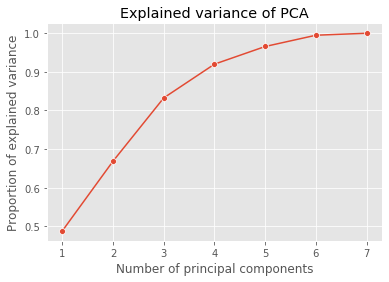

In [1492]:
ax = sns.lineplot(x=range(1,8), y=cumsum, marker='o')
ax.set_title('Explained variance of PCA')
ax.set_ylabel('Proportion of explained variance')
ax.set_xlabel('Number of principal components');

We see that 2 principal components explain nearly 0.7 of the variance in the data, and 4 components explain over 0.9 of the variance in the data. After that point, additional principal components don't add that much more to the proportion of explained variance. We'll retain the first 4 components.

In [1493]:
pc_df = pd.DataFrame(data_pca.components_[0:4]) 
pc_df.columns = df.columns
pc_df.index= np.arange(1, len(pc_df)+1)
pc_df.index.name = 'Principal component'
pc_df

Crime Subcategory,FAMILY,LIQUOR,PROPERTY,PUBLIC,SEXUAL,SUBSTANCE,VIOLENT
Principal component,,,,,,,
1,-0.171566,0.382163,0.185612,0.465279,0.314374,0.492426,0.481940
2,-0.047982,0.458267,0.742186,-0.086363,-0.425363,-0.189740,-0.111601
3,0.869004,0.282789,0.013588,-0.008662,0.302738,-0.235809,0.131705
4,-0.107397,-0.266917,0.499054,-0.128315,0.712146,0.019809,-0.379680


The 4 principal components can be used to summarize the data, with each principal component being a linear combination of the original crime subcategory variables. The principal components can be interpreted through their correlations with the crime subcategories (the higher the magnitude, the stronger the correlation):
- PC 1: Strong positive correlation with public, substance, and violent crime.
- PC 2: Strong positive correlation with property and liquor crime. Strong negative correlation with sexual crime. 
- PC 3: Strong positive correlation with non-violent family crime.
- PC 4: Strong postive correlation with sexual crime and property crime.

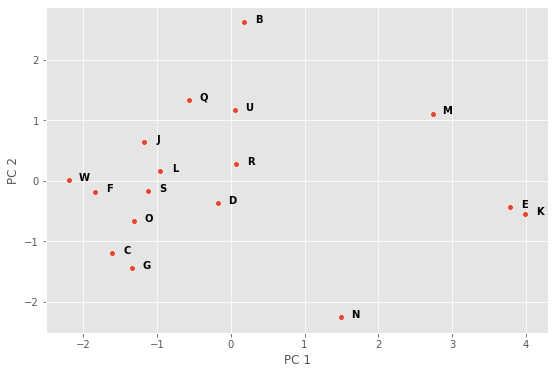

In [1494]:
#pca with 4 pcs
pca = PCA(4)
data_pca = pca.fit_transform(data) 

#plot with 2 pcs
labels = list(df.index)
plt.figure(figsize=(9,6))
ax = sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1])
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
for line in range(0,data_pca.shape[0]):
    ax.text(data_pca[:, 0][line]+0.2, data_pca[:, 1][line], labels[line],
            horizontalalignment='center', size='medium',
            color='black', weight='semibold');

Eyeballing the scatterplot, there seems to be 1 big cluster to the left where most sectors are, and N, M, E and K off to the side. But since we don't have information on the other principal components, we'll use a clustering algorithm like KMeans to cluster the observations. Since we don't know what k is, we'll apply KMeans over a range of ks and use the elbow method to determine the optimal k.

In [1496]:
wcss = []
for i in range(1,16):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=103)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

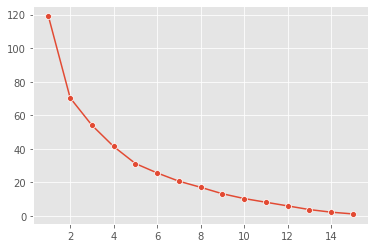

In [1497]:
sns.lineplot(x=range(1,16), y=wcss, marker='o');

From the graph, there isn't a clear elbow where we can definitively pick the optimal k. There seems to be somewhat of an elbow at 2 clusters and maybe at 5 and 8 clusters, but it might be subjective and justifications could be made for other cluster numbers as well. The choice of clusters could also be subject to the goals of the stakeholders. From the scatterplot above, it would seem that 2 clusters would be an oversimplification of the data, and 8 clusters may be too complex to analyze and not provide the benefits of clustering that we sought out to achieve, so we'll settle on 5 clusters. 

In [1498]:
k_opt = 5
k_mod = KMeans(n_clusters= k_opt, init='k-means++', random_state=1600)
k_mod.fit(data_pca)
k_mod.cluster_centers_

array([[ 3.5001531 ,  0.03653337, -0.45730979, -0.48831247],
       [-0.37729256,  1.43805402,  0.34238881,  0.51718405],
       [ 1.48824179, -2.25622406,  1.18127304,  2.08801713],
       [-1.3209574 , -0.55890511, -1.30660422,  0.16545111],
       [-1.03914025, -0.27399433,  0.8095036 , -0.67072407]])

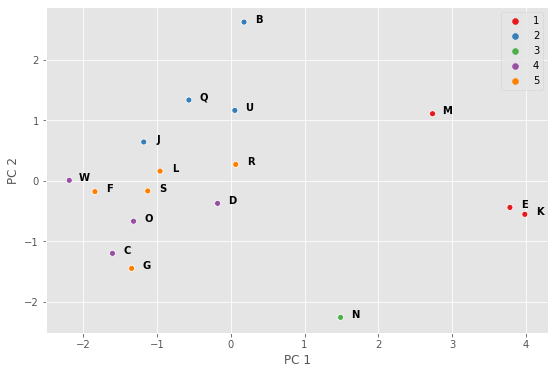

In [1499]:
# extract clusters
clusters = (k_mod.labels_ + 1).tolist()
clusters = [str(x) for x in clusters]

#plot with 2 pcs
labels = list(df.index)
plt.figure(figsize=(9,6))
ax = sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=clusters,
                    palette=sns.color_palette("Set1", 5))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
for line in range(0,data_pca.shape[0]):
    ax.text(data_pca[:, 0][line]+0.2, data_pca[:, 1][line], labels[line],
            horizontalalignment='center', size='medium',
            color='black', weight='semibold');

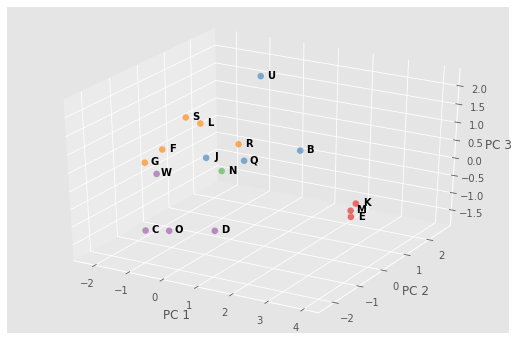

In [1500]:
#create dataframe for plotting
pc3 = pd.DataFrame({'PC 1' :data_pca[:, 0], 'PC 2':data_pca[:, 1], 'PC 3': data_pca[:, 2],
                    'cluster': clusters, 'cluster_num': k_mod.labels_})
colors = sns.color_palette("Set1", 5)

# plot with 3 pcas
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

xs = data_pca[:, 0]
ys = data_pca[:, 1]
zs = data_pca[:, 2]
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w',
           c=pc3['cluster_num'].apply(lambda x: colors[x]))

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

for line in range(0,data_pca.shape[0]):
    ax.text(data_pca[:, 0][line]+0.3, data_pca[:, 1][line], data_pca[:, 2][line],
            labels[line],
            horizontalalignment='center', size='medium',
            color='black', weight='semibold');
    
plt.show()

In [1501]:
k_mod.cluster_centers_

array([[ 3.5001531 ,  0.03653337, -0.45730979, -0.48831247],
       [-0.37729256,  1.43805402,  0.34238881,  0.51718405],
       [ 1.48824179, -2.25622406,  1.18127304,  2.08801713],
       [-1.3209574 , -0.55890511, -1.30660422,  0.16545111],
       [-1.03914025, -0.27399433,  0.8095036 , -0.67072407]])

These are the 5 clusters that KMeans algorithm produced. In the blob to the left of the 2d scatterplot, we see that KMeans separated the datapoints in a way we wouldn't have expected had we only used the first 2 principal components. The clusters are:

###### Cluster 1: M (Downtown), E (Capitol Hill), K (Pioneer Square)
Has high PC 1, and thus has high public, substance, and violent crime.

###### Cluster 2: B (Ballard/ Fremont), U (University District/ Sandpoint), Q (Magnolia/ Queen Anne), and  J (Green Lake).
Has high PC 2, which is associated with high property and liquor crime, and negatively associated with sexual crime.

###### Cluster 3:  N (Bitter Lake/ Northgate)
Has low PC 2, thus has low property and liquor crime, but positively associated with sexual crime. 

###### Cluster 4: W (West Seattle), O (East Georgetown), D (South Lake Union), C (Madison Valley)
Low PC 1 and low PC3, so associated with low public, substance, violent, and non-violent family crime.  

###### Cluster 5: F (West Georgetown), S (Rainier Valley/ Beacon Hill South), L (Lake City), R (Rainier Valley/ Beacon Hill North)
Low PC 4, which is associated with low non-violent family crime.

Apart from cluster 1, which is a clear cluster of its own characterized by high public, substance, and violent crime, the clustering and interpretation of the rest of the clusters is somewhat murkier. This is because the clusters are not as clearly separable, and in addition, the principal components being a linear combination of the original variables add to the challenge of interpretation.

Some possible future analyses are:
- Using the proportion of crime per category within each sector instead of just the count. This would find groupings in sectors in terms of crime category proportions, but would ignore the effect of absolute numbers of incidents in sectors.
- Using other clustering algorithms like hierarchical clustering to compare the clusters produced.